In [1]:
import torch, torchvision.transforms as T
from torchvision import models
from PIL import Image
import os, glob, pandas as pd, numpy as np, scipy.stats as stats, matplotlib.pyplot as plt, seaborn as sns
from torchvision.models import alexnet, AlexNet_Weights
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from matplotlib import colormaps
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import ast
from scipy.stats import spearmanr
from tqdm import tqdm
from scipy.stats import linregress
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial.distance import pdist, squareform



## grab subj data, and account for flips and shape-valence associations

In [91]:
df_subjs = pd.DataFrame()

for subj in ['amisha', 'tori', 'adam', 'erfan']:
    
    df_subj = pd.read_csv(glob.glob(f'../results/*{subj}*')[0])[:240]
    df_subj = df_subj.sort_values(by='trial_key').reset_index(drop=True)

    # store if flipped
    df_subj['flipped'] = np.where( df_subj['shape_order'] == 'curv_flat', 0, 1) 
   
    # convert str to list and store chosen position
    for col in ['positions']:
        if type(df_subj[col][0]) == str:
            df_subj[col] = df_subj[col].apply(lambda x: ast.literal_eval(x))
    df_subj['chosen_pos'] = df_subj['positions'].apply(lambda x: x[-1])
    
    # flips to ensure curvs are always on the left and flats on the right
    df_subj['chosen_pos_flipped'] = np.where( df_subj['flipped'] == 0, df_subj['chosen_pos'], -df_subj['chosen_pos'] )
    df_subj['div_true'] = np.where( df_subj['flipped'] == 0, df_subj['div_pos'], -df_subj['div_pos']) 

    # store correct class
    df_subj['class_true'] = np.where( df_subj['valence'] == 'rew', 1, 0 )

    if df_subj['sess_type'][0] in ['A', 'C']: # adam, tori
        
        # reassociate shape-valence
        df_subj['condition'] = df_subj['condition'].map({'baseline': 'baseline', 'curv_comp': 'pen_comp', 'flat_comp': 'rew_comp'})
        # store chosen class
        df_subj['class_pred'] = np.where( df_subj['chosen_pos_flipped'] > df_subj['div_true'], 1, 0 )

        # align positions to valence
        df_subj['chosen_pos_aligned'] = df_subj['chosen_pos_flipped']
        df_subj['stim_pos_aligned'] = df_subj['stim_pos']
        df_subj['div_true_aligned'] = df_subj['div_true']

    elif df_subj['sess_type'][0] in ['B', 'D']: # amisha, erfan
        
        # reassociate shape-valence
        df_subj['condition'] = df_subj['condition'].map({'baseline': 'baseline', 'curv_comp': 'rew_comp', 'flat_comp': 'pen_comp'})
        # store chosen class
        df_subj['class_pred'] = np.where( df_subj['chosen_pos_flipped'] < df_subj['div_true'], 1, 0 )
        
        # align positions to valence
        df_subj['chosen_pos_aligned'] = -df_subj['chosen_pos_flipped']
        df_subj['stim_pos_aligned'] = -df_subj['stim_pos']
        df_subj['div_true_aligned'] = -df_subj['div_true']

    df_subjs = pd.concat([df_subjs, df_subj], ignore_index=True)

# drop no slider move to no response submission
df_subjs = df_subjs.dropna(subset=['slider_resp.keys', 'submit_resp.keys'])
# compute y - y_hat
df_subjs['diff_pos'] = df_subjs['chosen_pos_aligned'] - df_subjs['stim_pos_aligned']

print(df_subjs.shape)
disp_cols = ['subj', 'sess_type', 'blockN', 'trial_key', 'condition', 'div_true_aligned', 'shape_order', 'flipped', 'div_pos', 'shape', 'valence', 'stim_pos', 'stim_pos_aligned', 'chosen_pos', 'chosen_pos_aligned', 'diff_pos', 'target_pos', 'chosen_pos', 'class_true', 'class_pred']
df_subjs[df_subjs['subj'] == 'amisha'][disp_cols][40:80]
df_subjs[disp_cols].head(10)


(914, 144)


,subj,sess_type,blockN,trial_key,condition,div_true_aligned,shape_order,flipped,div_pos,shape,valence,stim_pos,stim_pos_aligned,chosen_pos,chosen_pos_aligned,diff_pos,target_pos,chosen_pos,class_true,class_pred
0,amisha,B,1.0,0.0,baseline,-0.0,curv_flat,0,0.0,curv,rew,-0.38,0.38,-0.172,0.172,-0.208,-0.38,-0.172,1,1
1,amisha,B,1.0,1.0,baseline,0.0,flat_curv,1,0.0,curv,rew,-0.38,0.38,0.176,0.176,-0.204,0.38,0.176,1,1
2,amisha,B,1.0,2.0,baseline,-0.0,curv_flat,0,0.0,curv,rew,-0.34,0.34,-0.136,0.136,-0.204,-0.34,-0.136,1,1
3,amisha,B,1.0,3.0,baseline,0.0,flat_curv,1,0.0,curv,rew,-0.34,0.34,0.272,0.272,-0.068,0.34,0.272,1,1
5,amisha,B,1.0,5.0,baseline,0.0,flat_curv,1,0.0,curv,rew,-0.30,0.30,0.144,0.144,-0.156,0.30,0.144,1,1
6,amisha,B,1.0,6.0,baseline,-0.0,curv_flat,0,0.0,curv,rew,-0.26,0.26,-0.164,0.164,-0.096,-0.26,-0.164,1,1
7,amisha,B,1.0,7.0,baseline,0.0,flat_curv,1,0.0,curv,rew,-0.26,0.26,0.064,0.064,-0.196,0.26,0.064,1,1
9,amisha,B,1.0,9.0,baseline,0.0,flat_curv,1,0.0,curv,rew,-0.22,0.22,0.112,0.112,-0.108,0.22,0.112,1,1
10,amisha,B,1.0,10.0,baseline,-0.0,curv_flat,0,0.0,curv,rew,-0.18,0.18,-0.116,0.116,-0.064,-0.18,-0.116,1,1
12,amisha,B,1.0,12.0,baseline,-0.0,curv_flat,0,0.0,curv,rew,-0.14,0.14,-0.088,0.088,-0.052,-0.14,-0.088,1,1


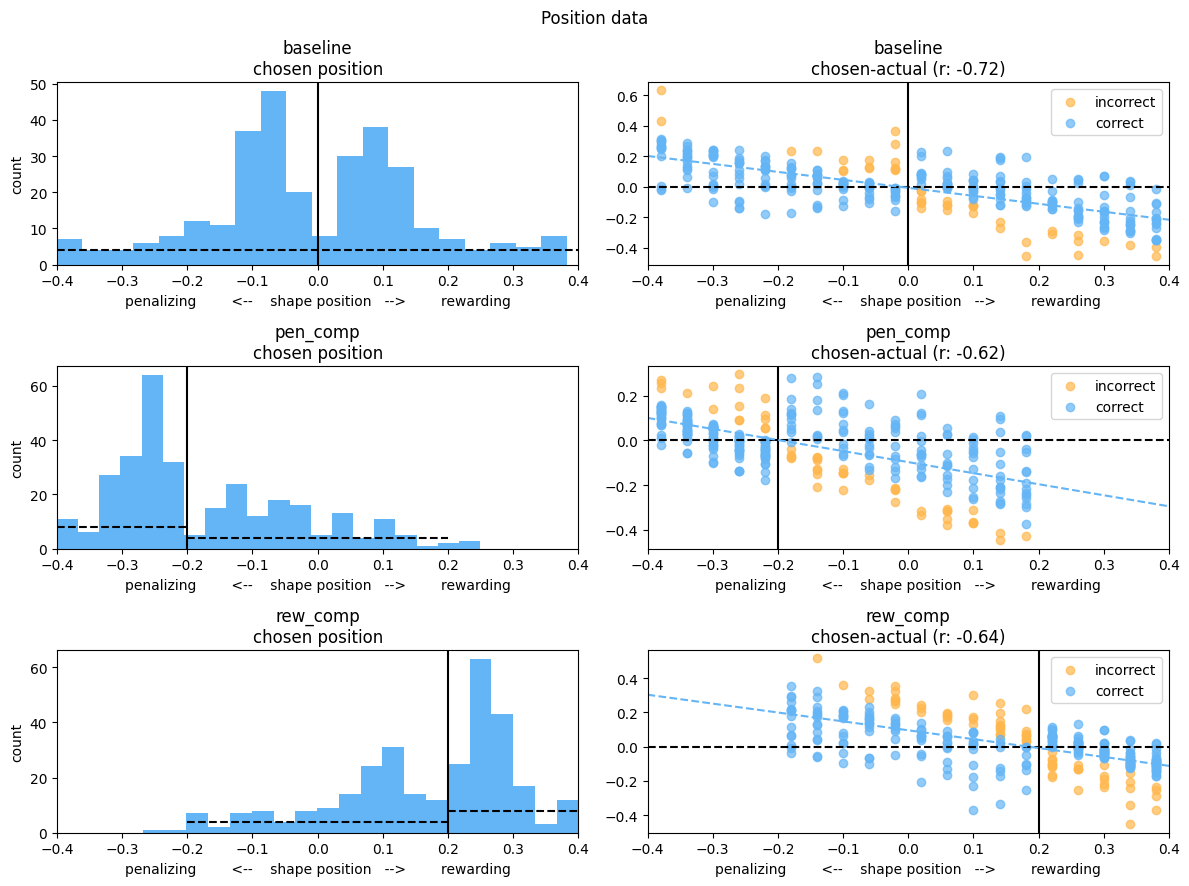

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(12, 9))
axs, ax = axs.flatten(), 0

# plot info
light_blue, light_orange = '#64B5F6', '#FFB74D'
color_map = {False: light_orange, True: light_blue}
label_map = {False: 'incorrect', True: 'correct'}

df_subj = df_subjs[df_subjs['subj'] == 'amisha']
# for cond, cond_df in df_subj[df_subjs['outcome'] != 0].groupby('condition'):
for cond, cond_df in df_subjs[df_subjs['outcome'] != 0].groupby('condition'):

    axs[ax].hist(cond_df['chosen_pos_aligned'], bins=20, color=light_blue)
    
    if cond == 'baseline':
        axs[ax].axhline(16/4, color='black', linestyle='--', label='true dist')
    elif cond == 'pen_comp':
        axs[ax].hlines(32/4, -.4, -.2, color='black', linestyle='--', label='true dist')
        axs[ax].hlines(16/4, -.2, .2, color='black', linestyle='--', label='true dist')
    elif cond == 'rew_comp':
        axs[ax].hlines(16/4, -.2, .2, color='black', linestyle='--', label='true dist')
        axs[ax].hlines(32/4, .2, .4, color='black', linestyle='--', label='true dist')
    axs[ax].axvline(cond_df['div_true_aligned'].iloc[0], color='black', linestyle='-', label='divider')
    axs[ax].set_xlim(-.4, .4)
    # axs[ax].set_ylim(0, 20)
    axs[ax].set_xlabel('penalizing        <--    shape position   -->        rewarding')
    axs[ax].set_ylabel('count')
    # axs[ax].legend()
    axs[ax].set_title(f'{cond}\nchosen position')
    ax += 1    


    for acc, acc_df in cond_df.groupby('correct'):        
        axs[ax].scatter(acc_df['stim_pos_aligned'], acc_df['diff_pos'],
                        color=color_map[acc], label=label_map[acc], alpha=0.7)
    axs[ax].axhline(0, color='black', linestyle='--')
    axs[ax].axvline(cond_df['div_true_aligned'].iloc[0], color='black', linestyle='-')
    axs[ax].set_xlim(-.4, .4)
    axs[ax].set_xlabel('penalizing        <--    shape position   -->        rewarding')
    axs[ax].legend()
    # fit line
    slope, intercept, r_val, p_val, std_err = linregress(cond_df['stim_pos_aligned'], cond_df['chosen_pos_aligned']-cond_df['stim_pos_aligned'])
    x_fit = np.array(axs[ax].get_xlim())
    y_fit = intercept + slope * x_fit
    axs[ax].plot(x_fit, y_fit, linestyle='--', color=light_blue)
    axs[ax].set_title(f'{cond}\nchosen-actual (r: {r_val:.2f})')
    ax += 1

plt.suptitle('Position data')
plt.tight_layout()
plt.show()
fig.subplots_adjust(hspace=0.8, wspace=0.4)


## get alexnet embeddings of stims used in expt

In [5]:
# # load pretrainded AlexNet model
# model = models.alexnet(weights=AlexNet_Weights.DEFAULT).eval()
# # remove the last layer to get the feature vector
# model.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-1])
# # transform the input image to the format expected by the model
# transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# def get_embeddings(img_path):
#     img = np.array(Image.open(img_path).convert('RGB'))
#     # img = np.clip(img + np.random.normal(loc=0.0, scale=100, size=img.shape), 0, 255)
#     img = Image.fromarray(img.astype(np.uint8))
#     img = transform(img).unsqueeze(0)
#     with torch.no_grad():
#     # with torch.no_grad() is used to disable gradient calculation
#         return model(img)
    
    
# # 1. Load trial metadata
# trials_df = pd.read_csv('../input_data/trials_no_noise.csv')
# shape_files_used = trials_df['target_file'].tolist()

# # 2. Extract AlexNet embeddings

# alex_embeds = [(shape_file, get_embeddings(os.path.join('../', shape_file))) for shape_file in tqdm(shape_files_used)]
# embedding_matrix = np.stack([v.squeeze().numpy() for _, v in alex_embeds])
# shape_names = [k for k, _ in alex_embeds]

# # 3. Apply PCA to embeddings
# pca = PCA(n_components=64)
# pca_features = pca.fit_transform(embedding_matrix)
# # add noise
# # pca_features += np.random.normal(loc=0.0, scale=5, size=pca_features.shape)

# # 4. Form DataFrame: shape name + PCA features
# pca_cols = [f'feature_{i}' for i in range(pca_features.shape[1])]
# alexnet_df = pd.DataFrame(pca_features, columns=pca_cols)
# alexnet_df.insert(0, 'shapes', shape_names)

# # 5. Append more metadata
# alexnet_df[['blockN', 'condition', 'stim_pos', 'target_pos', 'noise_pos', 'div_pos']] = trials_df[['blockN', 'condition', 'stim_pos', 'target_pos', 'noise_pos', 'div_pos']]
# alexnet_df['flipped'] = np.where( trials_df['shape_order'] == 'curv_flat', 0, 1) 
# alexnet_df['condition'] = trials_df['condition'].map({'baseline': 'baseline', 'curv_comp': 'pen_comp', 'flat_comp': 'rew_comp'})
# alexnet_df['div_true'] = alexnet_df['condition'].map({'baseline': 0, 'pen_comp': -.2, 'rew_comp': .2})
# alexnet_df['class_true'] = np.where( trials_df['shape'] == 'flat', 1, 0 )

# # 7. Reorder and save
# reorder_columns = ['shapes', 'blockN', 'condition', 'div_true', 'flipped', 'div_pos', 'stim_pos', 'target_pos', 'class_true', 'noise_pos'] + pca_cols
# alexnet_df = alexnet_df[reorder_columns]

# alexnet_df.to_csv('../input_data/alex_embeds.csv', index=False)


In [6]:
alexnet_df = pd.read_csv('../input_data/alex_embeds.csv')
print(alexnet_df.shape)
alexnet_df[:40]
# alexnet_df.iloc[75:85]

(240, 74)


,shapes,blockN,condition,div_true,flipped,div_pos,stim_pos,target_pos,class_true,noise_pos,...,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63
0,input_data/stims/Shape_0.10_2.00.png,1,baseline,0.0,0,0.0,-0.38,-0.38,0,2.0,...,-8.771358e-13,-8.308965e-13,1.922047e-13,-3.426131e-13,2.724970e-13,1.986201e-13,-2.445504e-14,2.013994e-13,2.613542e-13,-6.299245e-14
1,input_data/stims/Shape_0.10_2.00.png,1,baseline,0.0,1,0.0,-0.38,0.38,0,2.0,...,-9.627584e-13,-2.876314e-13,1.310890e-13,-4.862357e-13,-9.706319e-14,-4.722665e-13,-1.166362e-14,-2.482920e-13,1.635390e-14,-6.093387e-14
2,input_data/stims/Shape_0.30_2.00.png,1,baseline,0.0,0,0.0,-0.34,-0.34,0,2.0,...,4.589276e-13,6.898096e-15,-4.088004e-13,4.411045e-13,-2.657446e-13,8.011019e-13,9.688545e-14,4.556923e-14,4.840898e-14,-1.440877e-14
3,input_data/stims/Shape_0.30_2.00.png,1,baseline,0.0,1,0.0,-0.34,0.34,0,2.0,...,-1.419930e-13,7.489344e-14,8.354695e-13,1.088127e-13,2.373954e-13,2.131295e-13,-3.420512e-14,1.065259e-13,1.591025e-13,-8.087193e-14
4,input_data/stims/Shape_0.50_2.00.png,1,baseline,0.0,0,0.0,-0.30,-0.30,0,2.0,...,-7.724709e-13,-7.475767e-13,9.251255e-14,-6.081292e-13,4.165303e-13,-1.442081e-13,-3.267067e-14,9.158333e-14,-1.498787e-14,1.421475e-13
5,input_data/stims/Shape_0.50_2.00.png,1,baseline,0.0,1,0.0,-0.30,0.30,0,2.0,...,3.890766e-13,1.246005e-12,7.049917e-13,2.186398e-13,-1.883614e-13,9.971964e-14,6.043537e-14,-4.248936e-14,7.518468e-14,1.644357e-13
6,input_data/stims/Shape_0.70_2.00.png,1,baseline,0.0,0,0.0,-0.26,-0.26,0,2.0,...,2.023836e-13,-9.554073e-13,8.329584e-13,-6.132623e-13,7.082411e-13,-1.011541e-13,6.124499e-14,-1.867023e-13,-1.261609e-13,1.156512e-13
7,input_data/stims/Shape_0.70_2.00.png,1,baseline,0.0,1,0.0,-0.26,0.26,0,2.0,...,-1.742855e-12,-3.586453e-13,3.527091e-13,-7.888043e-13,-9.560183e-13,-4.585924e-13,1.178583e-13,-2.088258e-13,-2.063374e-13,-7.942870e-15
8,input_data/stims/Shape_0.90_2.00.png,1,baseline,0.0,0,0.0,-0.22,-0.22,0,2.0,...,5.389250e-13,-4.533952e-13,-3.398312e-13,-3.910867e-14,3.368468e-13,2.107689e-13,7.365344e-14,-1.681255e-13,1.280035e-13,7.467758e-15
9,input_data/stims/Shape_0.90_2.00.png,1,baseline,0.0,1,0.0,-0.22,0.22,0,2.0,...,2.823984e-13,-7.849563e-14,4.746939e-13,-3.547137e-13,-3.133474e-13,1.119487e-13,-5.849712e-15,-8.343721e-14,-1.475780e-13,1.414096e-13


## plot stim embeddings from alexnet

alex_embeds_df.shape (n_trials, n_feats): (240, 64)


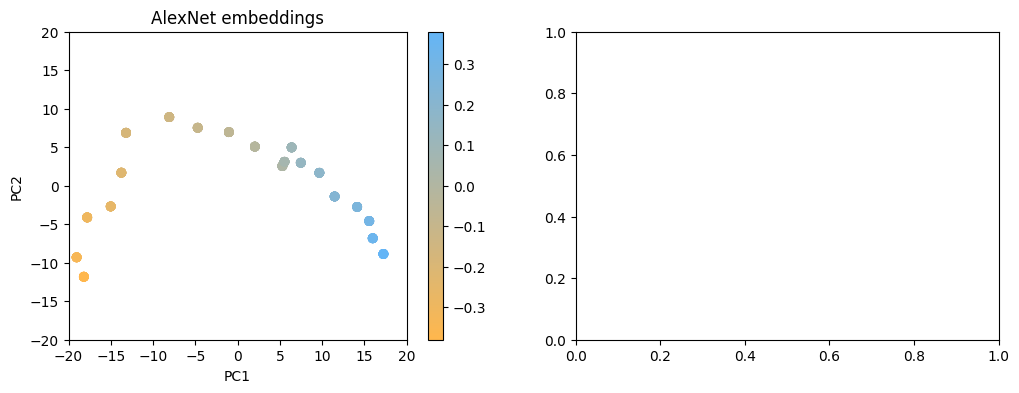

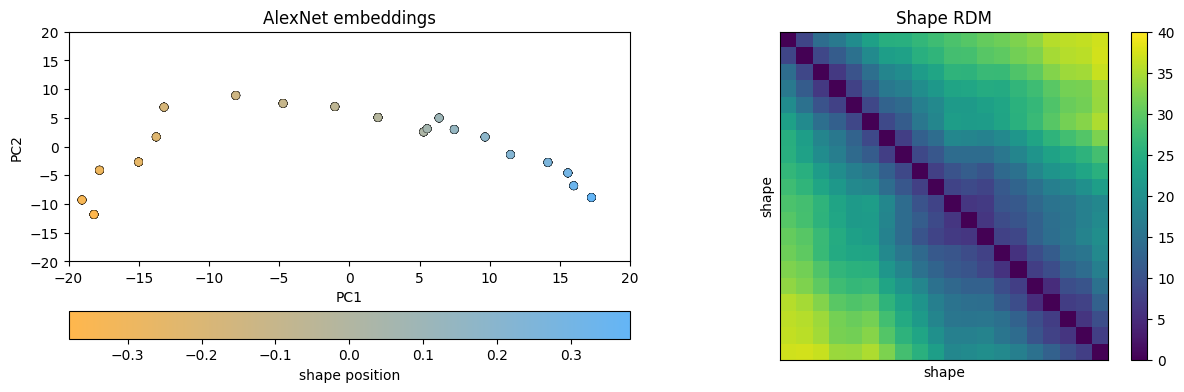

<Figure size 640x480 with 0 Axes>

In [38]:
# sub-select cols
alex_embeds_df = alexnet_df[alexnet_df.columns[alexnet_df.columns.str.startswith('feature_')]]
print(f'alex_embeds_df.shape (n_trials, n_feats): {alex_embeds_df.shape}')

pca = PCA(n_components=2)
alex_feat_pc_df = pd.DataFrame(pca.fit_transform(alex_embeds_df),
                               columns=['PC1', 'PC2'])



fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs, ax = axs.flatten(), 0
cmap = LinearSegmentedColormap.from_list('orange_blue', ['#FFB74D', '#64B5F6'])

axs[ax].scatter(alex_feat_pc_df['PC1'], alex_feat_pc_df['PC2'], c = alexnet_df['stim_pos'].values, cmap=cmap)
cbar = plt.colorbar(axs[ax].collections[0], ax=axs[ax])
axs[ax].set_xlabel('PC1')
axs[ax].set_ylabel('PC2')
axs[ax].set_xlim(-20,20)
axs[ax].set_ylim(-20,20)
axs[ax].set_title('AlexNet embeddings')
ax += 1


feat_by_shape = alex_embeds_df.groupby(alexnet_df['shapes']).mean()
shape_rdm = squareform(pdist(feat_by_shape.values, metric='euclidean'))

# 3️⃣ Plot PCs + shape RDM side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs, ax = axs.flatten(), 0

# — PC scatter (unchanged) —
sc = axs[ax].scatter(
    alex_feat_pc_df['PC1'], alex_feat_pc_df['PC2'],
    c=alexnet_df['stim_pos'].values,
    cmap=cmap, edgecolor='k', linewidth=0.2
)
fig.colorbar(sc, ax=axs[ax], label='shape position', orientation='horizontal')
axs[ax].set(xlabel='PC1', ylabel='PC2', xlim=(-20,20), ylim=(-20,20), title='AlexNet embeddings')
ax += 1

# — shape‐by‐shape RDM —
im = axs[ax].imshow(shape_rdm, cmap='viridis', vmin=0, vmax=40)
axs[ax].set_xticks([])
axs[ax].set_yticks([])
axs[ax].set(title='Shape RDM', xlabel='shape', ylabel='shape')
# label ticks with your shape names
shape_labels = feat_by_shape.index.tolist()
# axs[ax].set_xticks(range(len(shape_labels)))
# axs[ax].set_yticks(range(len(shape_labels)))
# axs[ax].set_xticklabels(shape_labels, rotation=90)
# axs[ax].set_yticklabels(shape_labels)
fig.colorbar(im, ax=axs[ax], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()


## building architecture of new NN

In [8]:
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim

class ShapeSideNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, recon_dim, class_dim):
        super(ShapeSideNN, self).__init__()
        
        # single intermediate layer
        self.hidden = nn.Linear(input_dim, hidden_dim)
        
        # separate outputs
        self.reconstruction_output = nn.Linear(hidden_dim, recon_dim)
        self.classification_output = nn.Linear(hidden_dim, class_dim)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        
        # output for reconstruction (continuous)
        reconstruction = self.reconstruction_output(x)
        
        # sigmoid output for classification (binary)
        # classification = torch.sigmoid(self.classification_output(x))
        classification = self.classification_output(x)
        
        return reconstruction, classification

## format features (X) & predictions (y_reg & y_class)

In [9]:
# 1.
feature_cols = [col for col in alexnet_df.columns if col.startswith('feature_')]
# features = alex embeds + div_pos + flipped
X = np.column_stack((alexnet_df[feature_cols].values,
                     alexnet_df['div_pos'].values,alexnet_df['flipped'].values))

# 2.
y_class = alexnet_df['class_true'].values.reshape(-1, 1) # shape class (0 or 1)

# 3.
y_reg = alexnet_df['target_pos'].values.reshape(-1, 1) # regression target
# y_reg = df_subjs[df_subjs['subj'] == 'tori']['chosen_pos'].values.reshape(-1, 1)
print(y_reg.tolist())

print(f'X.shape (n_trials, n_feats + div_cntxt): {X.shape}')

def weight_per_sample(labels, preds, tp, tn, fp, fn):
    weights = torch.ones_like(preds)  # init to all 1s
    weights[(labels == 1) & (preds == 1)] = tp  # true positive
    weights[(labels == 0) & (preds == 0)] = tn  # true negative
    weights[(labels == 0) & (preds == 1)] = fp  # false positive
    weights[(labels == 1) & (preds == 0)] = fn  # false negative
    return weights

[[-0.38], [0.38], [-0.34], [0.34], [-0.3], [0.3], [-0.26], [0.26], [-0.22], [0.22], [-0.18], [0.18], [-0.14], [0.14], [-0.1], [0.1], [-0.06], [0.06], [-0.02], [0.02], [0.02], [-0.02], [0.06], [-0.06], [0.1], [-0.1], [0.14], [-0.14], [0.18], [-0.18], [0.22], [-0.22], [0.26], [-0.26], [0.3], [-0.3], [0.34], [-0.34], [0.38], [-0.38], [-0.38], [0.38], [-0.38], [0.38], [-0.34], [0.34], [-0.34], [0.34], [-0.3], [0.3], [-0.3], [0.3], [-0.26], [0.26], [-0.26], [0.26], [-0.22], [0.22], [-0.22], [0.22], [-0.18], [0.18], [-0.14], [0.14], [-0.1], [0.1], [-0.06], [0.06], [-0.02], [0.02], [0.02], [-0.02], [0.06], [-0.06], [0.1], [-0.1], [0.14], [-0.14], [0.18], [-0.18], [-0.18], [0.18], [-0.14], [0.14], [-0.1], [0.1], [-0.06], [0.06], [-0.02], [0.02], [0.02], [-0.02], [0.06], [-0.06], [0.1], [-0.1], [0.14], [-0.14], [0.18], [-0.18], [0.22], [-0.22], [0.22], [-0.22], [0.26], [-0.26], [0.26], [-0.26], [0.3], [-0.3], [0.3], [-0.3], [0.34], [-0.34], [0.34], [-0.34], [0.38], [-0.38], [0.38], [-0.38], [-0

## cross-validation

reg_wt: 0.2, class_wt: 0.8, tp: 1, tn: 1, fp: 1, fn: 1
random state: 145
(1800, 10)


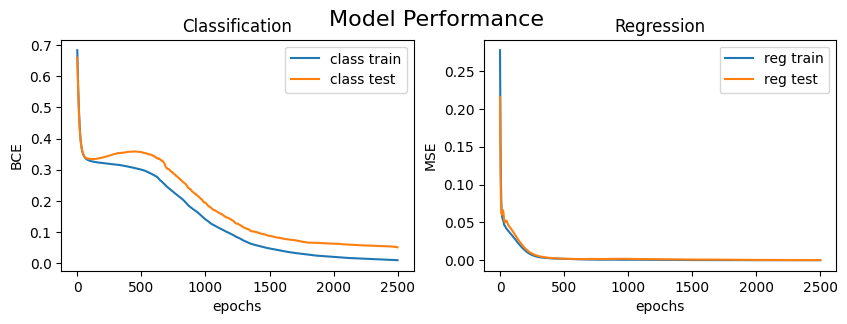

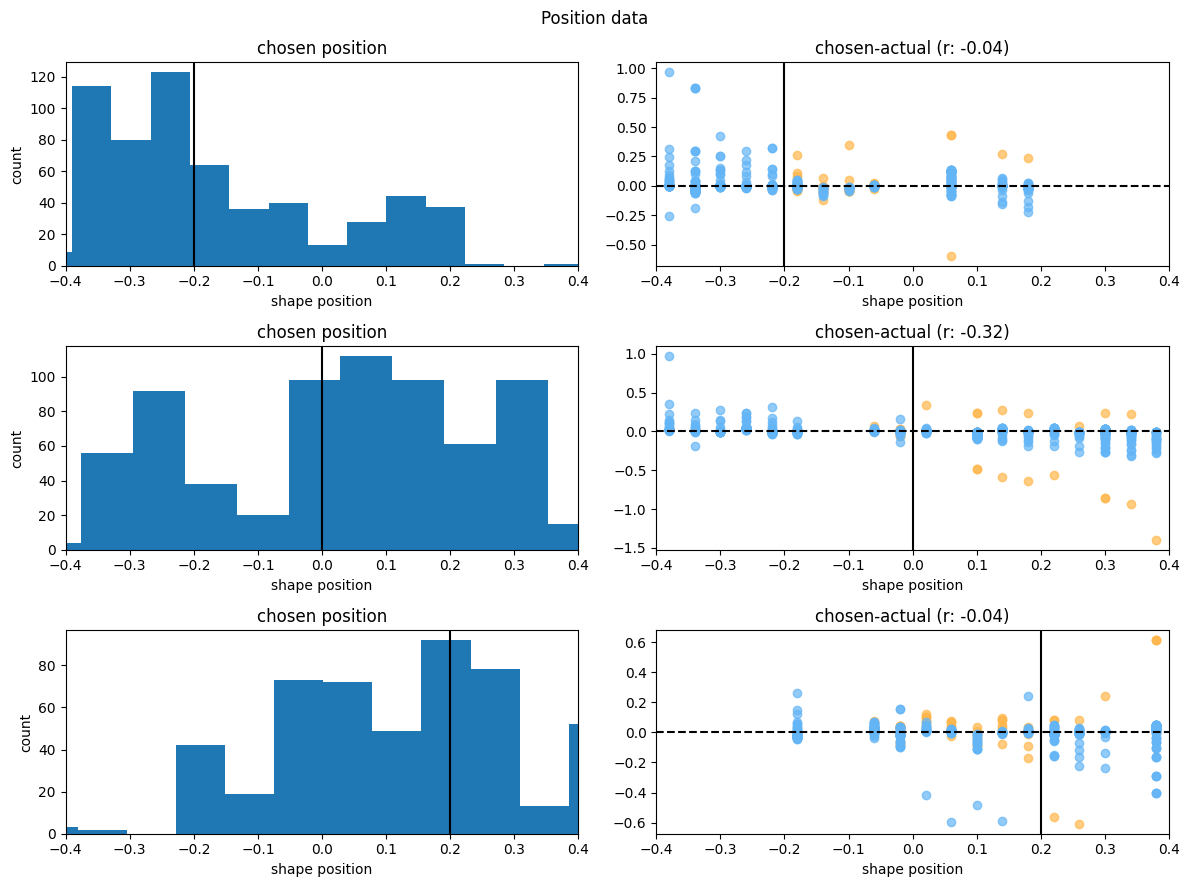

,divs,flips,y_reg_test,pred_reg_test,y_class_test,pred_class_test,correct,divs_flipped,y_reg_test_flipped,pred_reg_test_flipped
0,0.2,1.0,-0.06,0.539241,1.0,0.0,False,-0.2,0.06,-0.539241
1,0.0,1.0,-0.30,0.556902,1.0,0.0,False,-0.0,0.30,-0.556902
2,0.2,0.0,0.38,0.996838,1.0,0.0,False,0.2,0.38,0.996838
3,-0.2,0.0,-0.34,0.493964,0.0,0.0,True,-0.2,-0.34,0.493964
4,-0.2,0.0,-0.18,-0.124619,1.0,0.0,False,-0.2,-0.18,-0.124619
...,...,...,...,...,...,...,...,...,...,...
1795,-0.2,0.0,-0.30,-0.302818,0.0,0.0,True,-0.2,-0.30,-0.302818
1796,0.2,0.0,0.18,0.187086,0.0,0.0,True,0.2,0.18,0.187086
1797,0.2,1.0,0.26,0.263790,0.0,0.0,True,-0.2,-0.26,-0.263790
1798,-0.2,1.0,-0.10,-0.090033,0.0,0.0,True,0.2,0.10,0.090033


In [57]:
# architecture params
input_dim, hidden_dim, reg_dim, class_dim = X.shape[1], 64, y_reg.shape[1], 1
model = ShapeSideNN(input_dim, hidden_dim, reg_dim, class_dim)

# loss params
optimizer = optim.Adam(model.parameters(), lr=0.001)
reg_wt, class_wt = .2, .8
tp, tn, fp, fn = 6, 4, 0, 2
tp, tn, fp, fn = 1, 1, 1, 1
print(f'reg_wt: {reg_wt}, class_wt: {class_wt}, tp: {tp}, tn: {tn}, fp: {fp}, fn: {fn}')

rand_state = np.random.randint(0, 1000)
rand_state = 145
# ANN seeds: 334, 517, 145
# ANN asymmetric seeds: 
# NN seeds: amisha , erfan , tori 726, adam 
print(f'random state: {rand_state}')

train_total_losses, train_reg_losses, train_class_losses = [], [], []
test_total_losses, test_reg_losses, test_class_losses = [], [], []
all_divs, all_flips, all_y_reg, all_pred_reg, all_y_class, all_pred_class, all_epochs = [], [], [], [], [], [], []

epochs = 2500

# training loop
for epoch in range(epochs):

    # split into train and test
    X_train, X_test, y_reg_train, y_reg_test, y_class_train, y_class_test = train_test_split(
        X, y_reg, y_class, test_size=.3, stratify=y_class, shuffle=True, random_state=rand_state
    )

    # convert ys to tensors to be able to compare against preds
    y_reg_train, y_class_train = torch.tensor(y_reg_train, dtype=torch.float32), torch.tensor(y_class_train, dtype=torch.float32)
    y_reg_test, y_class_test = torch.tensor(y_reg_test, dtype=torch.float32), torch.tensor(y_class_test, dtype=torch.float32)
   
    model.train()

    # forward pass to predict regstruction & class
    pred_reg_train, pred_class_train = model(torch.tensor(X_train, dtype=torch.float32))

    # 1. regstruction loss between pred & y
    train_reg_loss = nn.MSELoss()(pred_reg_train, y_reg_train)

    # 2. class loss
    train_class_loss = nn.BCEWithLogitsLoss()(pred_class_train, y_class_train)

    # 2. classification loss
    # a. first get BCE per sample
    # no reduction means it unpacks, doesnt just avg out samples
    bce = nn.BCEWithLogitsLoss(reduction='none')(pred_class_train, y_class_train)
    
    # b. next, get binary classes
    pred_class_train_binarized = (torch.sigmoid(pred_class_train) >= .5).float()

    # c. get weight per sample depending on (true, pred)
    wts = weight_per_sample(y_class_train.squeeze(), pred_class_train_binarized.squeeze(), tp, tn, fp, fn)

    # d. weighted error
    train_class_loss = (wts * bce).mean()

    # 3. weighted summed training loss
    train_total_loss = (reg_wt * train_reg_loss) + (class_wt * train_class_loss)

    # backward pass and optimization
    optimizer.zero_grad()
    train_total_loss.backward()
    # to try to take care of exploding gradients (manifested as sudden, high losses)?
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    # testing model
    model.eval()
    with torch.no_grad():

        # predict test shape & class using trained model
        pred_reg_test, pred_class_test = model(torch.tensor(X_test, dtype=torch.float32))        

        # 1. reg losses between pred & y
        test_reg_loss = nn.MSELoss()(pred_reg_test, y_reg_test)

        # 2. class loss
        test_class_loss = nn.BCEWithLogitsLoss()(pred_class_test, y_class_test)

        # 2. class loss
        # a. first get BCE per sample
        # no reduction means it unpacks, doesnt just avg out samples
        bce = nn.BCEWithLogitsLoss(reduction='none')(pred_class_test, y_class_test)
        
        # b. next, get binary classes
        pred_class_test_binarized = (torch.sigmoid(pred_class_test) >= .5).float()

        # c. get weight per sample depending on (true, pred)
        wts = weight_per_sample(y_class_test.squeeze(), pred_class_test_binarized.squeeze(), tp, tn, fp, fn)

        # d. weighted error
        test_class_loss = (wts * bce).mean()
    
        # 3. weighted summed testing loss
        test_total_loss = (reg_wt * test_reg_loss) + (class_wt * test_class_loss)

    # appending train & test losses
    train_reg_losses.append(train_reg_loss.item())
    train_class_losses.append(train_class_loss.item())
    train_total_losses.append(train_total_loss.item())

    test_reg_losses.append(test_reg_loss.item())
    test_class_losses.append(test_class_loss.item())
    test_total_losses.append(test_total_loss.item())

    if epoch % 100 == 0:
        # appending ys, preds, divs, flips
        all_divs.append(X_test[:, -2])  # divider
        all_flips.append(X_test[:, -1])  # flip
        all_y_reg.append(y_reg_test.squeeze().numpy().flatten())
        all_pred_reg.append(pred_reg_test.squeeze().numpy().flatten())
        all_y_class.append(y_class_test.squeeze().numpy().flatten())
        all_pred_class.append(pred_class_test_binarized.squeeze().numpy().flatten())


    # stop early when class accuracy > .8 for last 5 epochs
    # loss_thresh = 0.2
    # if test_total_loss.item() <= loss_thresh:
    #     print(f'loss < {loss_thresh}, stopped at epoch {epoch}')
    #     break


df_outputs = pd.DataFrame({
    'divs': np.concatenate(all_divs),
    'flips': np.concatenate(all_flips),
    'y_reg_test': np.concatenate(all_y_reg),
    'pred_reg_test': np.concatenate(all_pred_reg),
    'y_class_test': np.concatenate(all_y_class),
    'pred_class_test': np.concatenate(all_pred_class)
})
df_outputs['correct'] = np.where(df_outputs['y_class_test'] == df_outputs['pred_class_test'], True, False)

# flip positions when required
df_outputs['divs_flipped'] = np.where(df_outputs['flips'] == 0, df_outputs['divs'], -df_outputs['divs'])
df_outputs['y_reg_test_flipped'] = np.where(df_outputs['flips'] == 0, df_outputs['y_reg_test'], -df_outputs['y_reg_test'])
df_outputs['pred_reg_test_flipped'] = np.where(df_outputs['flips'] == 0, df_outputs['pred_reg_test'], -df_outputs['pred_reg_test'])

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs, ax = axs.flatten(), 0
fig.suptitle('Model Performance', fontsize=16)

# 1. class loss
axs[ax].plot(train_class_losses, label='class train')
axs[ax].plot(test_class_losses, label='class test')
axs[ax].set_xlabel('epochs')
axs[ax].set_ylabel('BCE')
# axs[0].set_ylim(0, 5)
axs[ax].set_title('Classification')
axs[ax].legend()
ax += 1

# 2. reg loss
axs[ax].plot(train_reg_losses, label='reg train')
axs[ax].plot(test_reg_losses, label='reg test')
axs[ax].set_xlabel('epochs')
axs[ax].set_ylabel('MSE')
# axs[0].set_ylim(0, 5)
axs[ax].set_title('Regression')
axs[ax].legend()
ax += 1

fig, axs = plt.subplots(3, 2, figsize=(12, 9))
axs, ax = axs.flatten(), 0

print(df_outputs.shape)

for model_div, model_div_df in df_outputs.groupby('divs_flipped'):

    axs[ax].hist(model_div_df['pred_reg_test_flipped'], bins=20)
    # axs[ax].axhline(16, color='black', linestyle='--', label='true dist')
    axs[ax].axvline(model_div_df['divs_flipped'].iloc[0], color='black', linestyle='-', label='divider')
    axs[ax].set_xlim(-.4, .4)
    axs[ax].set_xlabel('shape position')
    axs[ax].set_ylabel('count')
    # axs[ax].legend()
    axs[ax].set_title(f'chosen position')
    ax += 1    

    # axs[ax].scatter(model_div_df['y_reg_test_flipped'], model_div_df['pred_reg_test_flipped']-model_div_df['y_reg_test_flipped'])
    for corr, sub_df in model_div_df.groupby('correct'):
        axs[ax].scatter(
            sub_df['y_reg_test_flipped'],
            sub_df['pred_reg_test_flipped'] - sub_df['y_reg_test_flipped'],
            color=color_map[corr],
            label=label_map[corr],
            alpha=0.7
        )
    axs[ax].axhline(0, color='black', linestyle='--')
    axs[ax].axvline(model_div_df['divs_flipped'].iloc[0], color='black', linestyle='-')
    axs[ax].set_xlim(-.4, .4)
    axs[ax].set_xlabel('shape position')
    # fit line
    slope, intercept, r_val, p_val, std_err = linregress(model_div_df['y_reg_test_flipped'], model_div_df['pred_reg_test_flipped']-model_div_df['y_reg_test_flipped'])
    x_fit = np.array(axs[ax].get_xlim())
    y_fit = intercept + slope * x_fit
    # axs[ax].plot(x_fit, y_fit, linestyle='--', color=light_blue)
    axs[ax].set_title(f'chosen-actual (r: {r_val:.2f})')
    ax += 1

plt.suptitle('Position data')
plt.tight_layout()
plt.show()

df_outputs


In [56]:
print(df_outputs['correct'].value_counts())

correct
True     1623
False     177
Name: count, dtype: int64


## extract & visualize hidden embeds

In [52]:
# Get hidden layer activations
with torch.no_grad():
    nn_hidden = model.hidden(torch.tensor(X, dtype=torch.float32)).numpy()

# create column names and convert to df
hidden_cols = [f'hidden_{i}' for i in range(nn_hidden.shape[1])]
hidden_df = pd.DataFrame(nn_hidden, columns=hidden_cols)
print(f'nn_hidden_df.shape (n_trials, n_hidden_units): {hidden_df.shape}')

pca = PCA(n_components=2)
hidden_pc_df = pd.DataFrame(pca.fit_transform(hidden_df), columns=['hidden_PC1', 'hidden_PC2'])

nn_df = pd.concat([alexnet_df.drop(columns=[col for col in alexnet_df.columns if col.startswith('features_')]),
                   hidden_df], axis=1)
# concat 2 hidden layer PC cols to main df
nn_df = pd.concat([nn_df, hidden_pc_df], axis=1)
print(f'nn_df.shape : {nn_df.shape}')

nn_df.iloc[75:85]

nn_hidden_df.shape (n_trials, n_hidden_units): (240, 64)
nn_df.shape : (240, 140)


,shapes,blockN,condition,div_true,flipped,div_pos,stim_pos,target_pos,class_true,noise_pos,...,hidden_56,hidden_57,hidden_58,hidden_59,hidden_60,hidden_61,hidden_62,hidden_63,hidden_PC1,hidden_PC2
75,input_data/stims/Shape_2.50_2.00.png,2,pen_comp,-0.2,1,0.2,0.10,-0.10,1,2.0,...,-0.000627,-0.121345,0.008328,-0.765775,0.321872,0.007535,0.679481,-0.653869,4.592350,3.239919
76,input_data/stims/Shape_2.70_2.00.png,2,pen_comp,-0.2,0,-0.2,0.14,0.14,1,2.0,...,0.000040,-0.685672,0.000680,0.766612,1.228293,-0.004192,1.177543,0.012191,7.654053,3.180007
77,input_data/stims/Shape_2.70_2.00.png,2,pen_comp,-0.2,1,0.2,0.14,-0.14,1,2.0,...,0.574273,-0.498564,0.010529,-0.769651,-0.186897,0.004128,1.087495,0.011266,6.640182,1.816430
78,input_data/stims/Shape_2.90_2.00.png,2,pen_comp,-0.2,0,-0.2,0.18,0.18,1,2.0,...,0.069591,-0.756626,-0.042593,-0.095678,0.707298,-0.001976,0.936070,0.010617,7.991713,2.536620
79,input_data/stims/Shape_2.90_2.00.png,2,pen_comp,-0.2,1,0.2,0.18,-0.18,1,2.0,...,0.643824,-0.569517,-0.032745,-1.631942,-0.707892,0.006344,0.846021,0.009693,6.977840,1.173041
80,input_data/stims/Shape_1.10_2.00.png,3,rew_comp,0.2,0,0.2,-0.18,-0.18,0,2.0,...,-0.593247,2.697591,-1.123254,2.446535,-1.926888,-1.159521,0.203439,1.222118,-8.444124,8.892196
81,input_data/stims/Shape_1.10_2.00.png,3,rew_comp,0.2,1,-0.2,-0.18,0.18,0,2.0,...,-0.933756,2.267717,1.125661,2.440634,-1.927620,1.160317,0.335643,2.828556,-9.177670,2.367297
82,input_data/stims/Shape_1.30_2.00.png,3,rew_comp,0.2,0,0.2,-0.14,-0.14,0,2.0,...,-1.178672,1.737379,-1.126925,2.398688,-1.787409,-1.160644,0.868891,0.467168,-5.861208,8.673485
83,input_data/stims/Shape_1.30_2.00.png,3,rew_comp,0.2,1,-0.2,-0.14,0.14,0,2.0,...,-1.519182,1.307506,1.121990,2.392787,-1.788141,1.159193,1.001095,2.073606,-6.594752,2.148585
84,input_data/stims/Shape_1.50_2.00.png,3,rew_comp,0.2,0,0.2,-0.10,-0.10,0,2.0,...,-0.480191,1.330660,-1.127450,1.402351,-0.795989,-1.161148,0.389110,-0.140482,-3.290025,8.754937


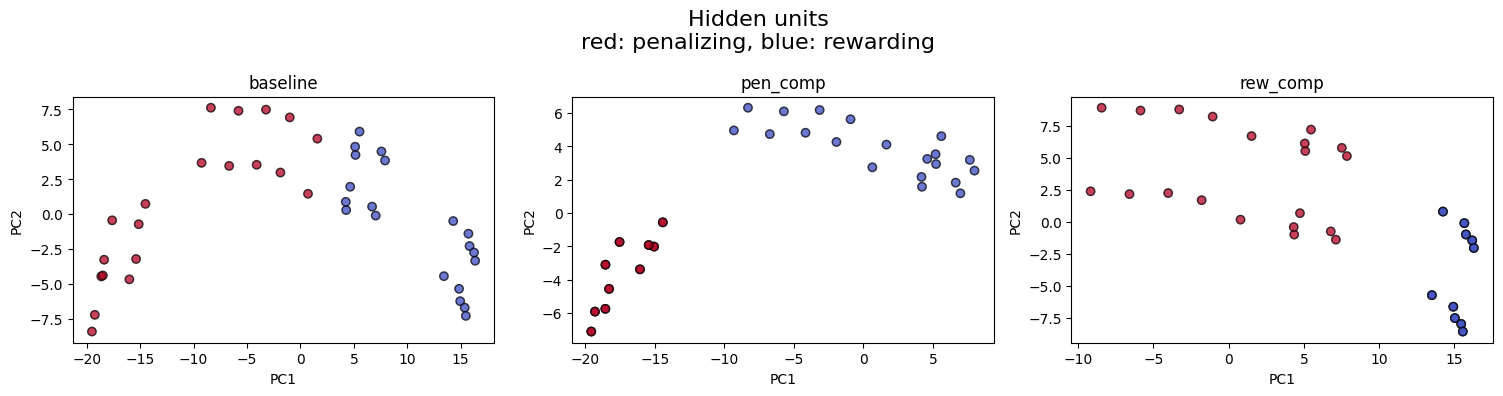

In [53]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs, ax = axs.flatten(), 0
fig.suptitle('Hidden units\nred: penalizing, blue: rewarding', fontsize=16)

for cond, cond_df in nn_df.groupby('condition'):
    
    scatter1 = axs[ax].scatter(cond_df['hidden_PC1'], cond_df['hidden_PC2'], c = cond_df['class_true'], cmap='coolwarm_r', edgecolor='k', alpha=0.5, marker='o')
    axs[ax].set_xlabel('PC1')
    axs[ax].set_ylabel('PC2')
    axs[ax].set_title(f'{cond}')
    ax += 1

plt.tight_layout()
plt.show()


## RDMs

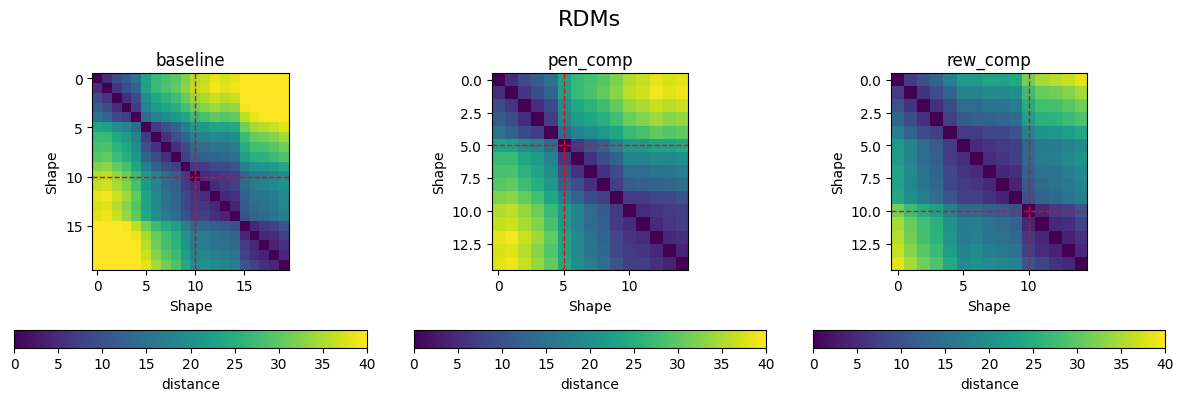

In [20]:
hidden_cols = [col for col in nn_df.columns if col.startswith('hidden_')]

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs, ax = axs.flatten(), 0
fig.suptitle('RDMs', fontsize=16)

for cond, cond_df in nn_df.groupby('condition'):

    # since the df has duplicate shapes, take avg
    shape_feats = cond_df.groupby('shapes')[hidden_cols].mean().values
    rdm = squareform(pdist(shape_feats, metric='euclidean'))

    im = axs[ax].imshow(rdm, cmap='viridis')
    im = axs[ax].imshow(rdm, cmap='viridis', vmin=0, vmax=40)
        # ▶ plot red divider line at condition-specific index
    n = shape_feats.shape[0]
    if   cond == 'baseline': idx = n // 2
    elif cond == 'pen_comp': idx = n // 3
    elif cond == 'rew_comp':  idx = 2 * n // 3
    else:                     idx = None

    if idx is not None:
        axs[ax].axhline(idx, color='red', linestyle='--', linewidth=1)
        axs[ax].axvline(idx, color='red', linestyle='--', linewidth=1)

    axs[ax].set_title(f'{cond}')
    axs[ax].set_xlabel('Shape')
    axs[ax].set_ylabel('Shape')
    
    fig.colorbar(im, ax=axs[ax], orientation='horizontal', pad=0.2, label='distance')
    ax += 1

plt.tight_layout()
plt.show()


## distance from neutral

In [90]:
# # 1. get 1D distance of each shape from divider
# nn_df['1D_dist_frm_div'] = nn_df['stim_pos'] - nn_df['div_true']

# # 2. get euclidean distance of each shape from divider
# euc_dists = []

# for shape_id in range(len(nn_df)):

#     div = nn_df['div_true'].iloc[shape_id]

#     # get indices of shapes to the immediate left and right of the divider
#     left_of_div_id = nn_df[np.isclose(nn_df['stim_pos'], div-.02)].index[0]
#     right_of_div_id = nn_df[np.isclose(nn_df['stim_pos'], div+.02)].index[0]

#     # compute centroid between shapes immediately left & right of div
#     centroid = np.mean([
#         hidden_df.iloc[left_of_div_id].values,
#         hidden_df.iloc[right_of_div_id].values
#     ], axis=0)

#     # store euclidean distance betw. shape and centroid
#     euc_dist = np.linalg.norm(hidden_df.iloc[shape_id].values - centroid)
#     euc_dists.append(euc_dist)

# nn_df['euc_dist_frm_div'] = euc_dists
# nn_df.iloc[75:85]


In [92]:
# fig, axs = plt.subplots(1, 3, figsize=(12, 4))
# axs, ax = axs.flatten(), 0
# fig.suptitle('Euclidean distance from divider', fontsize=16)
# jitter = .01

# for cond, cond_df in nn_df.groupby('condition'):

#     # plot euc dist (y) vs. 1D dist (x)
#     scatter = axs[ax].scatter(cond_df['1D_dist_frm_div'] + np.random.normal(0, jitter, size=len(cond_df)),
#                               cond_df['euc_dist_frm_div'] + np.random.normal(0, jitter, size=len(cond_df)),
#                               edgecolor='k', alpha=0.5, marker='o')

#     axs[ax].set_xlabel('1D distance')
#     axs[ax].set_ylabel('euclidean')
#     axs[ax].set_title(f'{cond}')
#     # axs[ax].set_ylim(0, 15)
#     axs[ax].set_xlim(-.4, .4)
#     ax += 1

# plt.tight_layout()
# plt.show()

## k-fold CV

In [56]:
# from sklearn.model_selection import KFold

# # architecture params
# input_dim, hidden_dim, output_dim = n_feats, 128, n_feats
# model = ShapeSideNN(input_dim, hidden_dim, output_dim)

# # loss params
# recon_loss_fn, class_loss_fn = nn.MSELoss(), nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# recon_wt, class_wt = 0, 5

# # convert to numpy arrays for compatibility with KFold
# X, y_recon, y_class = np.array(X), np.array(y_recon), np.array(y_class)

# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# fold_total_losses, fold_recon_losses, fold_class_losses = [], [], []
# epochs = 2500

# # CV loop
# for fold, (train_id, test_id) in enumerate(kf.split(X)):

#     print(f'fold {fold+1}', end=', ')

#     # split into train and test
#     X_train, X_test = X[train_id], X[test_id]
#     y_recon_train, y_recon_test = y_recon[train_id], y_recon[test_id]
#     y_class_train, y_class_test = y_class[train_id], y_class[test_id]

#     # initialize model, loss, and optimizer
#     model = ShapeSideNN(input_dim, hidden_dim, output_dim)
#     optimizer = optim.Adam(model.parameters(), lr=0.001)

#     epoch_total_losses, epoch_recon_losses, epoch_class_losses = [], [], []
#     beta = 3.0
#     # training loop
#     for epoch in range(epochs):
#         model.train()

#         # forward pass to predict reconstruction & class
#         pred_recon_train, pred_class_train = model(torch.tensor(X_train, dtype=torch.float32))
#         pred_class_train = torch.sigmoid(pred_class_train)

#         # calculate training losses between pred & y
#         train_recon_loss = recon_loss_fn(pred_recon_train, torch.tensor(y_recon_train, dtype=torch.float32))
#         train_class_loss = class_loss_fn(pred_class_train, torch.tensor(y_class_train, dtype=torch.float32))
#         # weighted sum
#         train_total_loss = recon_wt * train_recon_loss + class_wt * train_class_loss

#         # backward pass and optimization; training
#         optimizer.zero_grad()
#         train_total_loss.backward()
#         optimizer.step()

#         # testing model
#         model.eval()
#         test_total_losses, test_recon_losses, test_class_losses = [], [], []
#         with torch.no_grad():

#             # predict left-out (test) shape & class based using trained model on left-out embeddings
#             pred_recon_test, pred_class_test = model(torch.tensor(X_test, dtype=torch.float32))
#             pred_class_test = torch.sigmoid(pred_class_test)

#             # calculate testing losses between pred & y
#             test_recon_loss = recon_loss_fn(pred_recon_test, torch.tensor(y_recon_test, dtype=torch.float32))
#             test_class_loss = class_loss_fn(pred_class_test, torch.tensor(y_class_test, dtype=torch.float32))
#             test_total_loss = recon_wt * test_recon_loss + class_wt * test_class_loss

#         # appending epoch losses
#         epoch_recon_losses.append(test_recon_loss.item())
#         epoch_class_losses.append(test_class_loss.item())
#         epoch_total_losses.append(test_total_loss.item())

#     # appending fold losses
#     fold_recon_losses.append(epoch_recon_losses)
#     fold_class_losses.append(epoch_class_losses)
#     fold_total_losses.append(epoch_total_losses)

# # plot losses
# plt.figure(figsize=(8, 5))
# for i in range(5):
#     plt.plot(fold_total_losses[i], label=f'fold {i+1} class loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('5-fold CV')
# plt.legend()
# plt.show()
